In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import json
sys.path.append('/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/')
#from src.utils.logger_functions import console
from src.cmos_plotter.Plotter_Helper_KV import *
from src.cmos_plotter.Pair_activity_plotter import *

from src.utils.metadata_functions import load_metadata_as_dataframe
import logging
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)
import seaborn as sns

In [4]:
MAIN_PATH = '/itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/'

In [8]:
PROCESSED_DATA_PATH = os.path.join(MAIN_PATH,'Sorters')

In [17]:
import pickle
import numpy as np
import os
from pathlib import Path

def split_pickle_by_time(input_file, input_dir=None, output_dir=None, segment_duration=30.0):
    """
    Split a pickle file containing spike data into smaller pickle files based on time segments.
    Adjusts spike timestamps to be relative to the start of each segment.
    Ensures all unit indices from the original file are present in each segment.
    """
    # Create output directory if not provided
    if output_dir is None:
        output_dir = os.path.dirname(os.path.abspath(input_file))
    os.makedirs(output_dir, exist_ok=True)
    
    # Handle input directory
    if input_dir is None:
        input_dir = os.path.dirname(os.path.abspath(input_file))
    
    # Get base filename without extension
    base_filename = Path(input_file).stem
    
    # Load the pickle file
    with open(os.path.join(input_dir, input_file), 'rb') as f:
        data = pickle.load(f)
    
    # Extract needed data
    experiment_duration = data['EXPERIMENT_DURATION']
    spikemat = data['SPIKEMAT']
    spikemat_extremum = data['SPIKEMAT_EXTREMUM']
    
    # Get all unique unit indices from the original data
    all_unit_indices = np.unique(spikemat_extremum['UnitIdx'])
    
    # Create a mapping of unit indices to their corresponding electrodes
    unit_to_electrode = {}
    for row in spikemat_extremum:
        unit_to_electrode[row['UnitIdx']] = row['Electrode']
    
    # Calculate number of segments
    num_segments = int(np.ceil(experiment_duration / segment_duration))
    
    # Process each segment
    for segment_idx in range(num_segments):
        # Calculate segment time boundaries in milliseconds
        start_time_ms = segment_idx * segment_duration * 1000
        end_time_ms = min((segment_idx + 1) * segment_duration * 1000, experiment_duration * 1000)
        
        # For the first segment, remove the first 1000ms
        if segment_idx == 0:
            start_time_ms += 1000
        
        # Filter SPIKEMAT data for this segment
        segment_spikemat = spikemat[
            (spikemat['Spike_Time'] >= start_time_ms) & 
            (spikemat['Spike_Time'] < end_time_ms)
        ].copy()  # Make a copy to avoid modifying the original
        
        # Filter SPIKEMAT_EXTREMUM data for this segment
        segment_spikemat_extremum = spikemat_extremum[
            (spikemat_extremum['Spike_Time'] >= start_time_ms) & 
            (spikemat_extremum['Spike_Time'] < end_time_ms)
        ].copy()  # Make a copy to avoid modifying the original
        
        # IMPORTANT: Adjust spike times to be relative to the start of this segment
        segment_spikemat['Spike_Time'] -= start_time_ms
        segment_spikemat_extremum['Spike_Time'] -= start_time_ms
        
        # Get unit indices that are present in this segment
        present_unit_indices = np.unique(segment_spikemat_extremum['UnitIdx'])
        
        # Create dummy rows for missing unit indices
        missing_units = np.setdiff1d(all_unit_indices, present_unit_indices)
        
        if len(missing_units) > 0:
            # Create dummy rows for each missing unit
            dummy_rows = []
            
            for unit_idx in missing_units:
                # Get the electrode for this unit
                electrode = unit_to_electrode.get(unit_idx, "Unknown")
                
                # Create a dummy row with the correct dtype
                dummy_row = np.array([(electrode, 0.1, unit_idx)], 
                                     dtype=spikemat_extremum.dtype)
                dummy_rows.append(dummy_row)
            
            # Combine existing data with dummy rows
            if dummy_rows:
                dummy_array = np.concatenate(dummy_rows)
                segment_spikemat_extremum = np.concatenate([segment_spikemat_extremum, dummy_array])
        
        # Prepare segment data
        segment_data = data.copy()  # Copy all fields from original data
        segment_data['SPIKEMAT'] = segment_spikemat
        segment_data['SPIKEMAT_EXTREMUM'] = segment_spikemat_extremum
        segment_data['EXPERIMENT_DURATION'] = segment_duration  # Set to 30 seconds
        
        # For the first segment, adjust experiment duration if needed
        if segment_idx == 0 and end_time_ms - start_time_ms < segment_duration * 1000:
            segment_data['EXPERIMENT_DURATION'] = (end_time_ms - start_time_ms) / 1000
        
        # Save segment data to a new pickle file
        output_file = os.path.join(output_dir, f"{base_filename}_segment_{segment_idx+1}.pkl")
        with open(output_file, 'wb') as f:
            pickle.dump(segment_data, f)
        
        # Count units in this segment
        units_in_segment = len(np.unique(segment_spikemat_extremum['UnitIdx']))
        
        print(f"Saved segment {segment_idx+1}/{num_segments} to {output_file}")
        print(f"  Time range: {start_time_ms/1000:.3f}s - {end_time_ms/1000:.3f}s")
        print(f"  Adjusted time range: 0.000s - {(end_time_ms-start_time_ms)/1000:.3f}s")
        print(f"  SPIKEMAT entries: {len(segment_spikemat)}")
        print(f"  SPIKEMAT_EXTREMUM entries: {len(segment_spikemat_extremum)}")
        print(f"  Total units: {units_in_segment} (including {len(missing_units)} dummy units)")

In [19]:
filenames = os.listdir(PROCESSED_DATA_PATH)
filenames = [f for f in filenames if f.endswith('.pkl')]
for filename in filenames:
    split_pickle_by_time(filename, input_dir = PROCESSED_DATA_PATH, output_dir=os.path.join(PROCESSED_DATA_PATH, 'Split_files'), segment_duration=30.0)

Saved segment 1/7 to /itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Sorters_stimulation/250415_stimulation/Split_files/ID2816_0_DIV32_DATE20250415_1126_spontaneous_40Hz_0.raw_processed_segment_1.pkl
  Time range: 1.000s - 30.000s
  Adjusted time range: 0.000s - 29.000s
  SPIKEMAT entries: 52599
  SPIKEMAT_EXTREMUM entries: 2811
  Total units: 31 (including 0 dummy units)
Saved segment 2/7 to /itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Sorters_stimulation/250415_stimulation/Split_files/ID2816_0_DIV32_DATE20250415_1126_spontaneous_40Hz_0.raw_processed_segment_2.pkl
  Time range: 30.000s - 60.000s
  Adjusted time range: 0.000s - 30.000s
  SPIKEMAT entries: 48137
  SPIKEMAT_EXTREMUM entries: 2509
  Total units: 31 (including 0 dummy units)
Saved segment 3/7 to /itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/March2025_heart/Sorter

In [9]:
data = np.load(os.path.join(PROCESSED_DATA_PATH, 'ID2184_N7_DIV21_DATE20250404_1107_spontaneous_NGN2.raw_processed.pkl'), allow_pickle=True)

In [11]:
a = data['SPIKEMAT_EXTREMUM']
inidices = pd.DataFrame(data['SPIKEMAT_EXTREMUM']['UnitIdx']).to_numpy()

unit_ids = np.array(list(data["UNIT_TO_EL"]))[inidices]
unit_ids

array([[34],
       [77],
       [11],
       ...,
       [54],
       [73],
       [73]])

In [ ]:

df = pd.DataFrame(columns=['chip_id', 'area', 'div', 'num_units'])
for filename in filenames:
    filename_parts = filename.split('_')
    chip_id = int(filename_parts[0].replace('ID', ''))
    area = filename_parts[1].replace('N', '')
    div = int(filename_parts[2].replace('DIV', ''))
    data = np.load(os.path.join(PROCESSED_DATA_PATH, filename), allow_pickle=True)
    if data['UNIT_TO_EL'] == None:
        print(filename)
        continue
    else:
        num_units = len(data['UNIT_TO_EL'].keys())
        df = pd.concat([df, pd.DataFrame([{'chip_id': chip_id, 'area': area, 'div': div, 'num_units': num_units}])], ignore_index=True).reset_index(drop=True)
    

ID1297_N4_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N10_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N5_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N8_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N1_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N6_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1609_N3_DIV18_DATE20241203_1110_spontaneous_SpontaneousChip_HeartShape.raw_processed.pkl
ID1297_N2_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N9_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N3_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N7_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl
ID1297_N0_DIV28_DATE20241213_1203_spontaneous_.raw_processed.pkl


In [13]:
df = np.load(os.path.join(MAIN_PATH, 'Results/Num_units_per_DIV.pkl'), allow_pickle=True)
df

,chip_id,area,div,num_units
0,1297,3,26,75
1,1297,3,14,13
2,1652,3,28,43
3,1742,6,26,94
4,1609,1,18,46
...,...,...,...,...
124,1297,10,32,143
125,1609,2,26,61
126,1742,9,14,62
127,1625,3,28,59


In [14]:
df.groupby(['chip_id', 'div']).sum().reset_index()

,chip_id,div,area,num_units
0,1297,14,35647120,113
1,1297,18,14253607,280
2,1297,26,34270156,590
3,1297,32,312965847010,1034
4,1609,18,12405,197
5,1609,26,530142,392
6,1609,28,023514,456
7,1609,32,042351,509
8,1625,28,021453,285
9,1652,28,34201,274


2025-03-20 13:51:34,612 Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-20 13:51:34,613 Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-20 13:51:34,638 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-20 13:51:34,642 Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='div', ylabel='num_units'>

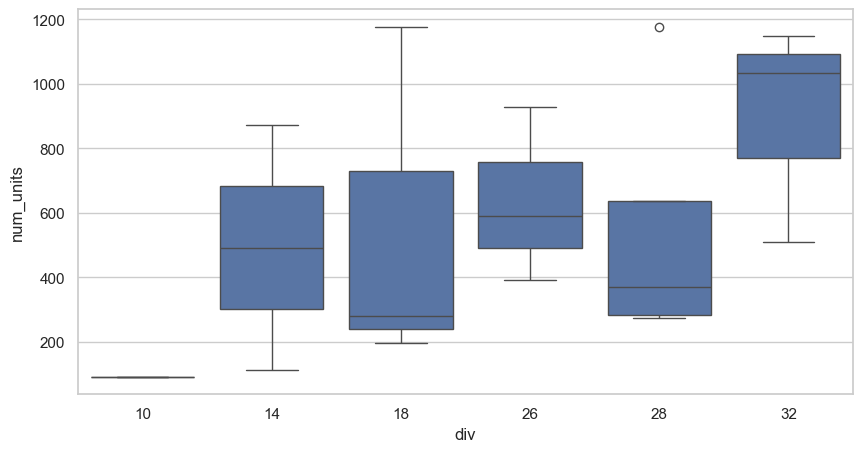

In [15]:
#summarize data per chip per div and then plot div vs num_units
df['div'] = pd.to_numeric(df['div'])
df['chip_id'] = pd.to_numeric(df['chip_id'])
df['area'] = pd.to_numeric(df['area'])
df['num_units'] = pd.to_numeric(df['num_units'])
df_2 = df.groupby(['chip_id', 'div']).sum().reset_index()
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.boxplot(x='div', y='num_units', data=df_2)

In [3]:
print("Starting neural data analysis...")

PAIRS_PATH = os.path.join(MAIN_PATH, 'biTE_new')

Starting neural data analysis...


In [4]:


# Analyze the data
results = analyze_neural_data(directory = PAIRS_PATH)

# Print summary information
print("\nSummary:")
print(f"Number of files processed: {len(results['files_metadata'])}")
print(f"Number of chips: {len(set(item['chip_id'] for item in results['files_metadata']))}")
print(f"DIVs analyzed: {sorted(set(item['div'] for item in results['files_metadata']))}")

if len(results['all_pairs_df']) > 0:
    print(f"Total source-target pairs: {len(results['all_pairs_df'])}")
    print(f"Lag range: {results['all_pairs_df']['lag'].min():.2f} - {results['all_pairs_df']['lag'].max():.2f} ms")
    print(f"Average lag: {results['all_pairs_df']['lag'].mean():.2f} ms")
else:
    print("No data pairs were extracted.")

# Generate and save plots
if len(results['pairs_plot_df']) > 0:
    print("\nGenerating plots...")
    plot_pairs_per_div(PAIRS_PATH,results['pairs_plot_df'])
    print("- Saved pairs_per_div.png")

if len(results['all_pairs_df']) > 0:
    plot_lag_vs_position(PAIRS_PATH,results['all_pairs_df'])
    print("- Saved lag_vs_position.png")
    
    plot_spatial_lag_map(PAIRS_PATH,results['all_pairs_df'])
    print("- Saved spatial_lag_map.png")

    plot_spatial_lag_map_per_chip(PAIRS_PATH,results['all_pairs_df'])

print("\nAnalysis complete!")

Found 121 pickle files
Successfully loaded ID1742_N7_DIV18_DATE20241203_1113_spontaneous.raw_processed_info_metrics.pkl
Error reading file ID1609_N0_DIV18_DATE20241203_1110_spontaneous_SpontaneousChip_HeartShape.raw_processed_info_metrics.pkl: 'validated_results'
Error reading file ID1742_N2_DIV10_DATE20241125_1031_spontaneous.raw_processed_info_metrics.pkl: 'validated_results'
Successfully loaded ID1625_N0_DIV28_DATE20230306_spontaneous.raw_processed_info_metrics.pkl
Successfully loaded ID1742_N8_DIV18_DATE20241203_1113_spontaneous.raw_processed_info_metrics.pkl
Error reading file ID1742_N6_DIV26_DATE20241211_1221_spontaneous_.raw_processed_info_metrics.pkl: 'validated_results'
Successfully loaded ID1297_N6_DIV18_DATE20241203_1109_spontaneous.raw_processed_info_metrics.pkl
Successfully loaded ID1297_N10_DIV32_DATE20241217_1112_spontaneous.raw_processed_info_metrics.pkl
Successfully loaded ID1742_N1_DIV18_DATE20241203_1113_spontaneous.raw_processed_info_metrics.pkl
Successfully loaded 

2025-03-20 15:47:58,666 Loaded backend module://matplotlib_inline.backend_inline version unknown.
2025-03-20 15:47:58,667 Loaded backend module://matplotlib_inline.backend_inline version unknown.


Successfully loaded ID1742_N1_DIV28_DATE20241213_1159_spontaneous.raw_processed_info_metrics.pkl

Summary:
Number of files processed: 121
Number of chips: 5
DIVs analyzed: ['10', '14', '18', '26', '28', '32']
Total source-target pairs: 16324
Lag range: 1.00 - 10.00 ms
Average lag: 4.36 ms

Generating plots...


2025-03-20 15:47:58,831 posx and posy should be finite values
2025-03-20 15:47:58,832 posx and posy should be finite values
2025-03-20 15:47:58,868 posx and posy should be finite values
2025-03-20 15:47:58,868 posx and posy should be finite values
2025-03-20 15:47:59,116 posx and posy should be finite values
2025-03-20 15:47:59,117 posx and posy should be finite values
2025-03-20 15:47:59,447 posx and posy should be finite values
2025-03-20 15:47:59,448 posx and posy should be finite values
2025-03-20 15:47:59,466 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-03-20 15:47:59,491 posx and posy should be finite values
2025-03-20 15:47:59,492 posx and posy should be finite values
2025-03-20 15:47:59,496 Assigning font /F2 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Bold.ttf'
2025-03-20 15:47:59,500 Emb

- Saved pairs_per_div.png


/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 16.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
2025-03-20 15:48:02,419 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-03-20 15:48:02,891 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-03-20 15:48:02,892 Writing TrueType font.
/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/seab

- Saved lag_vs_position.png


2025-03-20 15:48:03,946 locator: <matplotlib.ticker.AutoLocator object at 0x7f014291af10>
2025-03-20 15:48:04,004 locator: <matplotlib.ticker.AutoLocator object at 0x7f0142b132d0>
2025-03-20 15:48:04,048 locator: <matplotlib.ticker.AutoLocator object at 0x7f0142a9b210>
2025-03-20 15:48:04,166 locator: <matplotlib.ticker.AutoLocator object at 0x7f0142682910>
2025-03-20 15:48:04,210 locator: <matplotlib.ticker.AutoLocator object at 0x7f0142826050>
2025-03-20 15:48:04,338 locator: <matplotlib.ticker.AutoLocator object at 0x7f01426f2750>
2025-03-20 15:48:04,381 locator: <matplotlib.ticker.AutoLocator object at 0x7f0142499c50>
2025-03-20 15:48:06,194 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-03-20 15:48:06,647 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-03-20 15:48:06,647 Writi

- Saved spatial_lag_map.png


2025-03-20 15:48:10,100 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-03-20 15:48:10,142 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-03-20 15:48:10,142 Writing TrueType font.
2025-03-20 15:48:10,306 locator: <matplotlib.ticker.AutoLocator object at 0x7f0141cc4590>
2025-03-20 15:48:10,643 Assigning font /F1 = '/home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
2025-03-20 15:48:10,671 Embedding font /home/kvulic/Vulic/cmos_toolbox_w_spike_sorter/.venv/lib/python3.11/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
2025-03-20 15:48:10,672 Writing TrueType font.
2025-03-20 15:48:10,764 locator: <matplotlib.ticker.AutoLocator object at 0x7f0141bc3c50>
2025-03-20 15:48:10,846 locator: <matplotlib

Saved 20 individual chip-DIV plots to /itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Ferrans_processed_data_heart/biTE_new/per_chip_per_div
Saved combined plots to /itet-stor/kvulic/neuronies/single_neurons/1_Subprojects/Neurons_As_DNNs/3_Processed_Data/Ferrans_processed_data_heart/biTE_new

Analysis complete!


<Figure size 1200x600 with 0 Axes>

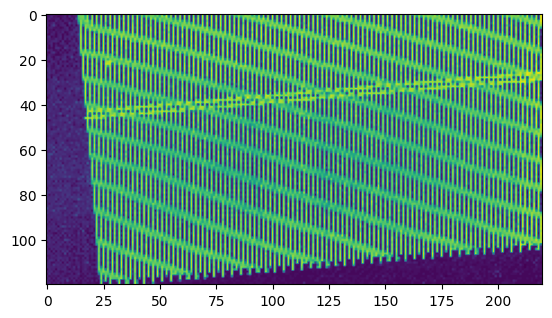

In [7]:
EL_SELECTIONS = os.path.join(MAIN_PATH, 'Electrode_selections')
el_selection = np.load(os.path.join(EL_SELECTIONS, '2024_02_06_1625_AS.npy'), allow_pickle=True)
plt.imshow(el_selection)
plt.show()

In [ ]:
import pickle
import numpy as np
import os
from pathlib import Path

def split_pickle_by_time_without_dummy(input_file, input_dir = None, output_dir=None, segment_duration=30.0):
    """
    Split a pickle file containing spike data into smaller pickle files based on time segments.
    Adjusts spike timestamps to be relative to the start of each segment.
    """
    # Create output directory if not provided
    if output_dir is None:
        output_dir = os.path.dirname(os.path.abspath(input_file))
    os.makedirs(output_dir, exist_ok=True)
    
    # Get base filename without extension
    base_filename = Path(input_file).stem
    
    # Load the pickle file
    with open(os.path.join(input_dir,input_file), 'rb') as f:
        data = pickle.load(f)
    
    # Extract needed data
    experiment_duration = data['EXPERIMENT_DURATION']
    spikemat = data['SPIKEMAT']
    spikemat_extremum = data['SPIKEMAT_EXTREMUM']
    
    # Calculate number of segments
    num_segments = int(np.ceil(experiment_duration / segment_duration))
    
    # Process each segment
    for segment_idx in range(num_segments):
        # Calculate segment time boundaries in milliseconds
        start_time_ms = segment_idx * segment_duration * 1000
        end_time_ms = min((segment_idx + 1) * segment_duration * 1000, experiment_duration * 1000)
        
        # For the first segment, remove the first 1000ms
        if segment_idx == 0:
            start_time_ms += 1000
        
        # Filter SPIKEMAT data for this segment
        segment_spikemat = spikemat[
            (spikemat['Spike_Time'] >= start_time_ms) & 
            (spikemat['Spike_Time'] < end_time_ms)
        ].copy()  # Make a copy to avoid modifying the original
        
        # Filter SPIKEMAT_EXTREMUM data for this segment
        segment_spikemat_extremum = spikemat_extremum[
            (spikemat_extremum['Spike_Time'] >= start_time_ms) & 
            (spikemat_extremum['Spike_Time'] < end_time_ms)
        ].copy()  # Make a copy to avoid modifying the original
        
        # IMPORTANT: Adjust spike times to be relative to the start of this segment
        segment_spikemat['Spike_Time'] -= start_time_ms
        segment_spikemat_extremum['Spike_Time'] -= start_time_ms
        
        # Prepare segment data
        segment_data = data.copy()  # Copy all fields from original data
        segment_data['SPIKEMAT'] = segment_spikemat
        segment_data['SPIKEMAT_EXTREMUM'] = segment_spikemat_extremum
        segment_data['EXPERIMENT_DURATION'] = segment_duration  # Set to 30 seconds
        
        # For the first segment, adjust experiment duration if needed
        if segment_idx == 0 and end_time_ms - start_time_ms < segment_duration * 1000:
            segment_data['EXPERIMENT_DURATION'] = (end_time_ms - start_time_ms) / 1000
        
        # Save segment data to a new pickle file
        output_file = os.path.join(output_dir, f"{base_filename}_segment_{segment_idx+1}.pkl")
        with open(output_file, 'wb') as f:
            pickle.dump(segment_data, f)
        
        print(f"Saved segment {segment_idx+1}/{num_segments} to {output_file}")
        print(f"  Time range: {start_time_ms/1000:.3f}s - {end_time_ms/1000:.3f}s")
        print(f"  Adjusted time range: 0.000s - {(end_time_ms-start_time_ms)/1000:.3f}s")
        print(f"  SPIKEMAT entries: {len(segment_spikemat)}")
        print(f"  SPIKEMAT_EXTREMUM entries: {len(segment_spikemat_extremum)}")
